In [18]:
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import pandas as pd
import sklearn
from utils import *
from models.MNL import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
%matplotlib inline
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# usps dataset from kaggle
import h5py
path = './data/usps.h5'
with h5py.File(path, 'r') as hf:
    train_data = hf.get('train')
    X_tr = np.array(train_data.get('data')[:])
    usps_y_tr = train_data.get('target')[:]
    test_data = hf.get('test')
    X_te = np.array(test_data.get('data')[:])
    usps_y_te = test_data.get('target')[:]


usps_X_tr = [[] for i in range(len(X_tr))]
usps_X_te = [[] for i in range(len(X_te))]

for i in range(len(X_tr)):
    temp = np.array(X_tr[i].reshape(16,16))
    temp = cv2.resize(temp, (28, 28), interpolation=cv2.INTER_CUBIC)
    usps_X_tr[i] = temp.flatten()

              
for i in range(len(X_te)):
    temp = np.array(X_te[i].reshape(16,16))
    temp = cv2.resize(temp, (28, 28), interpolation=cv2.INTER_CUBIC)
    usps_X_te[i] = temp.flatten()
    
usps_X_tr = np.array(usps_X_tr)
usps_X_te = np.array(usps_X_te)

print(np.array(usps_X_tr).shape, np.array(usps_X_te).shape)

(7291, 784) (2007, 784)


[9 6 3 6 6 0 0 0 6 9]


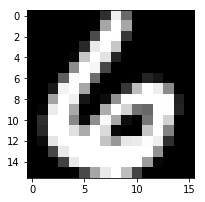

In [20]:
print(usps_y_te[:10])
pic_n = 1
fig, ax = plt.subplots(pic_n, 1, sharex = True, sharey = True, figsize=(3, 5))
for i in range(pic_n):
    ax.imshow(X_tr[0].reshape([16, 16]), 'gray')

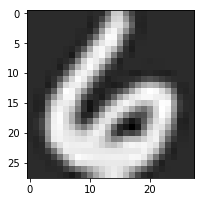

In [21]:
size=28
img = np.array(X_tr[0].reshape(16,16))
res = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
fig, ax = plt.subplots(pic_n, 1, sharex = True, sharey = True, figsize=(3, 5))
for i in range(pic_n):
    ax.imshow(res, 'gray')

In [22]:
data = MNIST(one_hot=False, shuffle=False)
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=False

# Hyper Parameters 
input_size = 784
num_classes = 10
batch_size = 1024
epochs = 50
learning_rate = 0.01
train_size = 1000
test_size = 1000

device = torch.device('cuda')
print(data.y_train.shape)
model = MNL(input_size, num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

x_train = torch.from_numpy(data.x_train[:train_size]).contiguous().view(-1, data.x_train.shape[1], 
                                          data.x_train.shape[2], data.x_train.shape[3])
y_train = torch.from_numpy(data.y_train[:train_size]).view(-1,).long()
print("train_size:", y_train.shape)

x_test = torch.from_numpy(data.x_test[:test_size]).contiguous().view(-1, data.x_train.shape[1], 
                                          data.x_train.shape[2], data.x_train.shape[3])
y_test = torch.from_numpy(data.y_test[:test_size]).view(-1,).long()
print("test_size:", y_test.shape)

train(model, device, x_train, y_train, batch_size, optimizer, criterion, epochs)
accuracy, avg_loss = evaluate(model, device, x_train, y_train, batch_size, criterion)
print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

usps_x_train = torch.from_numpy(usps_X_tr[-test_size:]).contiguous()
usps_y_train = torch.from_numpy(usps_y_tr[-test_size:]).view(-1,).long()
usps_x_test = torch.from_numpy(usps_X_te[-test_size:]).contiguous()
usps_y_test = torch.from_numpy(usps_y_te[-test_size:]).view(-1,).long()

print(usps_x_train.shape)

accuracy, avg_loss = evaluate(model, device, usps_x_train, usps_y_train, batch_size, criterion)
print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

(60000,)
train_size: torch.Size([1000])
test_size: torch.Size([1000])


[Train] Accuracy: 69.20%, loss:  0.0019
torch.Size([1000, 784])
[Test] Accuracy: 31.70%, loss:  0.0020


In [23]:
deep_f_train = []
deep_f_test = []
targets = []
for X, y in batch(x_train, y_train, batch_size):
    X = X.to(device).float()
    fc3, y_pre = model(X)
    deep_f_train.append(fc3.view(fc3.size(0), -1).cpu().detach().numpy())

for X, y in batch(usps_x_train, usps_y_train, batch_size):
    X = X.to(device).float()
    fc3, y_pre = model(X)
    deep_f_test.append(fc3.view(fc3.size(0), -1).cpu().detach().numpy())

deep_f_train = np.concatenate(deep_f_train) # deep features are not normalized
deep_f_test = np.concatenate(deep_f_test) # deep features are not normalized
print(deep_f_train.shape, deep_f_test.shape) 

(1000, 784) (1000, 784)


In [24]:
import math
kmin = 1
kmax = 10
kinterval = 1
fc1_knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))] # deep features
loo_fc1_knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))] # deep features

for i, k in enumerate(range(kmin, kmax, kinterval)):
    
#     fc1_knn_values[i],*_ = old_knn_shapley(k, deep_f[:train_data.shape[0]], deep_f[train_data.shape[0]:], 
#                                   y_deep[:train_data.shape[0]], y_deep[train_data.shape[0]:])
#     loo_fc1_knn_values[i],*_ = loo_knn_shapley(k, deep_f[:train_data.shape[0]], deep_f[train_data.shape[0]:], 
#                                   y_deep[:train_data.shape[0]], y_deep[train_data.shape[0]:])
    loo_fc1_knn_values[i], score, *_ = loo_knn_shapley(k, deep_f_train, deep_f_test, y_train, usps_y_train)
    print("neighbour number:", k, score)
    fc1_knn_values[i],*_ = old_knn_shapley(k, deep_f_train, deep_f_test, y_train, usps_y_train)

neighbour number: 1 0.617


neighbour number: 2 0.506


neighbour number: 3 0.602


neighbour number: 4 0.52


neighbour number: 5 0.575


neighbour number: 6 0.506


neighbour number: 7 0.543


neighbour number: 8 0.493


neighbour number: 9 0.537


(755,)
(147,)
(762,)
(220,)
(770,)
(310,)
(773,)
(356,)
(773,)
(339,)
(776,)
(415,)
(782,)
(410,)
(784,)
(477,)
(789,)
(444,)


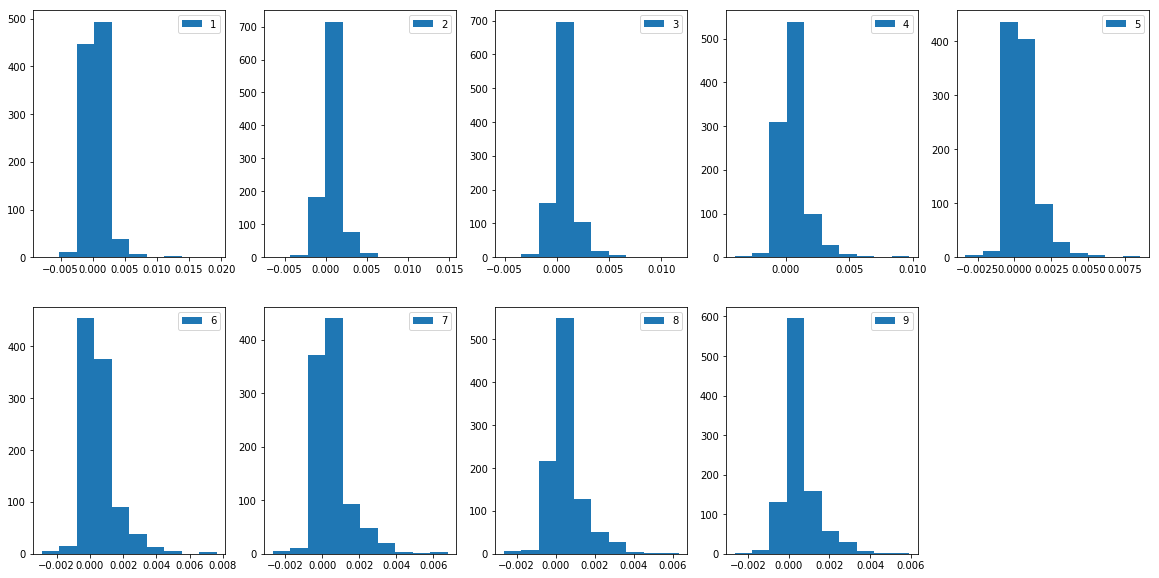

In [25]:
import pandas as pd
pd.options.display.max_columns = None
from IPython.display import display
class_weights = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
knn_values_idx = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
knn_values_advanced = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
loo_knn_values_idx = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
loo_knn_values_advanced = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]


#removing negative data
for i in range(len(fc1_knn_values)):
#     print(i)
    knn_values_idx[i] = np.where(fc1_knn_values[i] > 0)[0]
    knn_values_advanced[i] = fc1_knn_values[i][np.where(fc1_knn_values[i] > 0)[0]]
    print(knn_values_idx[i].shape)
    loo_knn_values_idx[i] = np.where(loo_fc1_knn_values[i] > 0)[0]
    loo_knn_values_advanced[i] = loo_fc1_knn_values[i][np.where(loo_fc1_knn_values[i] > 0)[0]]
    print(loo_knn_values_idx[i].shape)

    
    
#     for j in range(train_size):
#         if(fc1_knn_values[i][j]>0):
#             class_weights[i][targets[j]] += fc1_knn_values[i][j]

# for i in range(len(class_weights)):
#     print(class_weights[i])
fig=plt.figure(figsize=(20, 10))
for i, k in enumerate(range(kmin, kmax, kinterval)):
#     print(i,k)
    fig.add_subplot( 2, 5, i+1)
    plt.hist(fc1_knn_values[i].astype('float'), label=k)
    plt.legend()
plt.show()

In [26]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=False
epochs = 50
for i, k in enumerate(range(kmin, kmax, kinterval)):
    print("K=", k)
    device = torch.device('cuda')
    model = MNL(input_size, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#     weights = torch.FloatTensor(class_weights[i]).cuda()
#     criterion = nn.CrossEntropyLoss(weight=weights)
    criterion = nn.CrossEntropyLoss()

    x_train_val, y_train_val = x_train[knn_values_idx[i]], y_train[knn_values_idx[i]]
    print(x_train_val.shape, y_train_val.shape)
    train(model, device, x_train_val, y_train_val, batch_size, optimizer, criterion, epochs)
#     accuracy, avg_loss = evaluate(model, device, x_train_val, y_train_val, batch_size, criterion)
#     print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
    accuracy, avg_loss = evaluate(model, device, usps_x_train, usps_y_train, batch_size, criterion)
    print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

    model = MNL(input_size, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#     weights = torch.FloatTensor(class_weights[i]).cuda()
#     criterion = nn.CrossEntropyLoss(weight=weights)
    criterion = nn.CrossEntropyLoss()

    x_train_val, y_train_val = x_train[loo_knn_values_idx[i]], y_train[loo_knn_values_idx[i]]
    print(x_train_val.shape, y_train_val.shape)
    train(model, device, x_train_val, y_train_val, batch_size, optimizer, criterion, epochs)
#     accuracy, avg_loss = evaluate(model, device, x_train_val, y_train_val, batch_size, criterion)
#     print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
    accuracy, avg_loss = evaluate(model, device, usps_x_train, usps_y_train, batch_size, criterion)
    print(f'LOO [Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

K= 1
torch.Size([755, 28, 28, 1]) torch.Size([755])


[Test] Accuracy: 30.20%, loss:  0.0020
torch.Size([147, 28, 28, 1]) torch.Size([147])


LOO [Test] Accuracy: 27.90%, loss:  0.0021
K= 2
torch.Size([762, 28, 28, 1]) torch.Size([762])


[Test] Accuracy: 48.40%, loss:  0.0019
torch.Size([220, 28, 28, 1]) torch.Size([220])


LOO [Test] Accuracy: 39.40%, loss:  0.0019
K= 3
torch.Size([770, 28, 28, 1]) torch.Size([770])


[Test] Accuracy: 44.70%, loss:  0.0019
torch.Size([310, 28, 28, 1]) torch.Size([310])


LOO [Test] Accuracy: 35.10%, loss:  0.0020
K= 4
torch.Size([773, 28, 28, 1]) torch.Size([773])


[Test] Accuracy: 40.20%, loss:  0.0019
torch.Size([356, 28, 28, 1]) torch.Size([356])


LOO [Test] Accuracy: 32.80%, loss:  0.0020
K= 5
torch.Size([773, 28, 28, 1]) torch.Size([773])


[Test] Accuracy: 42.20%, loss:  0.0019
torch.Size([339, 28, 28, 1]) torch.Size([339])


LOO [Test] Accuracy: 41.80%, loss:  0.0020
K= 6
torch.Size([776, 28, 28, 1]) torch.Size([776])


[Test] Accuracy: 43.90%, loss:  0.0020
torch.Size([415, 28, 28, 1]) torch.Size([415])


LOO [Test] Accuracy: 35.40%, loss:  0.0021
K= 7
torch.Size([782, 28, 28, 1]) torch.Size([782])


[Test] Accuracy: 44.90%, loss:  0.0019
torch.Size([410, 28, 28, 1]) torch.Size([410])


LOO [Test] Accuracy: 36.30%, loss:  0.0019
K= 8
torch.Size([784, 28, 28, 1]) torch.Size([784])


[Test] Accuracy: 45.50%, loss:  0.0019
torch.Size([477, 28, 28, 1]) torch.Size([477])


LOO [Test] Accuracy: 33.50%, loss:  0.0021
K= 9
torch.Size([789, 28, 28, 1]) torch.Size([789])


[Test] Accuracy: 40.50%, loss:  0.0019
torch.Size([444, 28, 28, 1]) torch.Size([444])


LOO [Test] Accuracy: 41.00%, loss:  0.0019


In [29]:
# load data
import pickle
with open('./temp_domain/vals_tmc.pkl', 'rb') as f:
    tmc = pickle.load(f)
    tmc_values = tmc["vals_tmc"]
with open('./temp_domain/loo.pkl', 'rb') as f:
    loo = pickle.load(f)
    loo_values = loo["loo"]
print(loo_values.shape)
gloo_values_idx = []
tmc_values_idx = []

(1000,)


In [31]:
loo_values_idx = np.where(loo_values > 0)[0]
tmc_values_idx = np.where(tmc_values > 0)[0]
print(loo_values_idx.shape, tmc_values_idx.shape)

(131,) (605,)


In [32]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=False
device = torch.device('cuda')
model = MNL(input_size, num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train(model, device, x_train[tmc_values_idx], y_train[tmc_values_idx], batch_size, optimizer, criterion, epochs)

accuracy, avg_loss = evaluate(model, device, x_train[tmc_values_idx], y_train[tmc_values_idx], batch_size, criterion)
print(f'TMC [Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
accuracy, avg_loss = evaluate(model, device, usps_x_train, usps_y_train, batch_size, criterion)
print(f'TMC [Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

TMC [Test] Accuracy: 67.60%, loss:  0.0029
TMC [Test] Accuracy: 44.90%, loss:  0.0019


In [34]:
device = torch.device('cuda')
model = MNL(input_size, num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train(model, device, x_train[loo_values_idx], y_train[loo_values_idx], batch_size, optimizer, criterion, epochs)
accuracy, avg_loss = evaluate(model, device, usps_x_train[:test_size], usps_y_train[:test_size], batch_size, criterion)
print(f'LOO [Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

LOO [Test] Accuracy: 29.40%, loss:  0.0022
